# SVM CLASSIFICATION - T5 dataset - Fasttext Embedding method

In this notebook, we experiment with SVM models to classify emotion labels. By employing these techniques, we aim to analyze the effectiveness of each model in capturing the nuances of emtions expression in texts. This implementation is based on the T5 dataset and utilizes the Fasttext embedding method.

## Import library

In [1]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import gensim
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV
import spacy
from nltk import download
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

## Import data and preprocessing

In [3]:
data = pd.read_csv('data/train_t5.csv')

In [4]:
test_data = pd.read_csv('data/test_t5.csv')

In [10]:
# Download necessary NLTK resources
download('punkt')  # For tokenization
download('stopwords')  # For stopwords

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to C:\Users\minhd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\minhd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def preprocess_text(text):
    # Lowercase 
    text = text.lower()

    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Lemmatization (using SpaCy)
    doc = nlp(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]

    # Return to string 
    return " ".join(lemmatized_tokens)

In [12]:
# Preprocessing with training data
data['processed_text'] = data['text'].apply(preprocess_text)

In [13]:
# Preprocessing with test data 
test_data['processed_text'] = test_data['text'].apply(preprocess_text)

## Processing with Fasttext Embedding method

In [14]:
# Load pre-trained word embeddings from a file
model_path = 'wiki-news-300d-1M.vec'
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=False)

In [15]:
# Get the word vector
def get_word_vector(word, model):
    try:
        vector = model[word]
        return vector
    except KeyError:
        return None 

In [16]:
# Convert a sentence into a vector
def get_sentence_vector(sentence, model):
    words = sentence.split()  
    word_vectors = []
    
    for word in words:
        vector = get_word_vector(word, model)
        if vector is not None:
            word_vectors.append(vector)
    
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)  

    return np.mean(word_vectors, axis=0)

In [17]:
# Embedding with Fasttext
data['sentence_vector'] = data['processed_text'].apply(lambda x: get_sentence_vector(x, model))
test_data['sentence_vector'] = test_data['processed_text'].apply(lambda x: get_sentence_vector(x, model))

In [18]:
# Assigning the text from the training set
X_train = np.array(data['sentence_vector'].tolist())
y_train = data['label'].values  

# Assigning the text from the test set 
X_test = np.array(test_data['sentence_vector'].tolist())
y_test = test_data['label'].values  

In [19]:
# Initiate standardscaler and apply to data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print(class_weight_dict)

{'anger': 0.5499713486365322, 'fear': 1.3535755765720923, 'joy': 0.3753997653176265, 'love': 33.503080082135526, 'sadness': 1.4545778728715342, 'surprise': 16.186507936507937}


# Implement SVM 

In [26]:
# Implement Hyperparameters tunning
svm_model = SVC(kernel='rbf', class_weight=class_weight_dict) 
param_grid = {
    'C': loguniform(0.01, 100),  
    'gamma': ['scale', 'auto']  
}

optr_search = RandomizedSearchCV(
    estimator=svm_model, 
    param_distributions=param_grid, 
    cv=2, 
    n_iter=2, 
    n_jobs=-1, 
    verbose=True
)

optr_search.fit(X_train, y_train)

Fitting 2 folds for each of 2 candidates, totalling 4 fits


RandomizedSearchCV(cv=2,
                   estimator=SVC(class_weight={'anger': 0.5499713486365322,
                                               'fear': 1.3535755765720923,
                                               'joy': 0.3753997653176265,
                                               'love': 33.503080082135526,
                                               'sadness': 1.4545778728715342,
                                               'surprise': 16.186507936507937}),
                   n_iter=2, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001C2BE9DD5B0>,
                                        'gamma': ['scale', 'auto']},
                   verbose=True)

In [27]:
# Show the optimal parameters
optr_search.best_params_

{'C': 10.999382679501826, 'gamma': 'auto'}

In [33]:
# Retrieve model
best_model_rbf = optr_search.best_estimator_

In [28]:
# Show Clasification Report
optr_predictions = optr_search.best_estimator_.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, optr_predictions)}")

print("Classification Report:")
print(classification_report(y_test, optr_predictions))

Accuracy: 0.6921631118738253
Classification Report:
              precision    recall  f1-score   support

       anger       0.64      0.70      0.67      7417
        fear       0.57      0.50      0.53      3014
         joy       0.77      0.78      0.78     10865
        love       0.70      0.11      0.20       122
     sadness       0.65      0.58      0.62      2804
    surprise       0.67      0.34      0.45       252

    accuracy                           0.69     24474
   macro avg       0.67      0.50      0.54     24474
weighted avg       0.69      0.69      0.69     24474



In [38]:
# Show Confusion Matrix table
conf_matrix_rbf_weight_class = confusion_matrix(y_test, optr_predictions)
conf_matrix_rbf_weight_class

array([[5197,  535, 1363,    3,  313,    6],
       [ 792, 1494,  594,    1,  124,    9],
       [1471,  441, 8515,    2,  413,   23],
       [  41,    1,   56,   14,   10,    0],
       [ 567,  141,  457,    0, 1634,    5],
       [  48,   23,   89,    0,    6,   86]], dtype=int64)

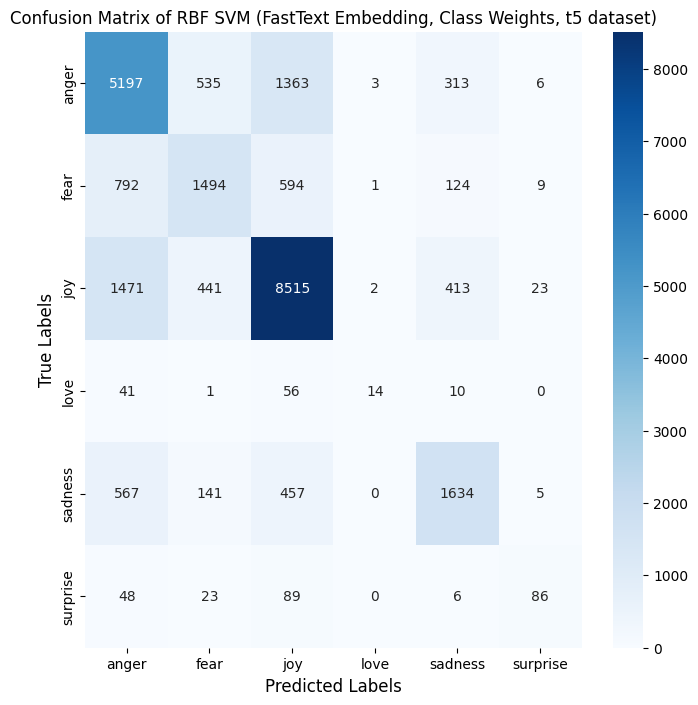

In [39]:
# Show confusion matrix figure
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix_rbf_weight_class, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'], 
            yticklabels=['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'])

plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix of RBF SVM (FastText Embedding, Class Weights, t5 dataset)', fontsize=12)
plt.show()

## Save metrics

In [42]:
def save_metrics_to_file(y_test, optr_predictions, file_name):
    # Accuracy
    accuracy = accuracy_score(y_test, optr_predictions)

    # Classification report
    class_report = classification_report(y_test, optr_predictions, output_dict=True)
    
    # Confusion matrix
    conf_matrix_linear = confusion_matrix(y_test, optr_predictions)

    # Extract metrics from the classification report
    macro_precision = class_report['macro avg']['precision']
    macro_recall = class_report['macro avg']['recall']
    macro_f1 = class_report['macro avg']['f1-score']
    
    weighted_precision = class_report['weighted avg']['precision']
    weighted_recall = class_report['weighted avg']['recall']
    weighted_f1 = class_report['weighted avg']['f1-score']
    
    # Replace invalid characters in the file name
    safe_file_name = file_name.replace(" ", "_").replace("(", "").replace(")", "").replace(",", "").replace("&", "and")
    # Save the results
    results_dir = 'results/results_SVM_classification/'
    
    # Create the full path for the results file
    metrics_filepath = os.path.join(results_dir, f'metrics_{safe_file_name}.txt')

    # Write the results to the file
    with open(metrics_filepath, 'w') as file:
        # Accuracy
        file.write(f"Test Accuracy: {accuracy:.4f}\n")
        file.write("\n")
        
        # Macro metrics
        file.write("Macro metrics\n")
        file.write(f"Macro precision: {macro_precision:.4f}\n")
        file.write(f"Macro recall: {macro_recall:.4f}\n")
        file.write(f"Macro F1 score: {macro_f1:.4f}\n")
        file.write("\n")
        
        # Weighted metrics
        file.write("Weighted metrics\n")
        file.write(f"Weighted precision: {weighted_precision:.4f}\n")
        file.write(f"Weighted recall: {weighted_recall:.4f}\n")
        file.write(f"Weighted F1 score: {weighted_f1:.4f}\n")
        file.write("\n")
        
        # Classification report
        file.write("Classification report:\n")
        file.write(classification_report(y_test, optr_predictions))
        file.write("\n")
        
        # Confusion matrix
        file.write("Confusion matrix:\n")
        file.write(np.array_str(conf_matrix_linear))
        file.write("\n")

In [43]:
SVM_rbf_fasttext_weight_T5 = "Non Linear SVM (Kernel RBF, FastText Embedding, Class Weights, T5 dataset)"
save_metrics_to_file(y_test, optr_predictions, SVM_rbf_fasttext_weight_T5)